<a href="https://colab.research.google.com/github/MalikArslanBashir/Data-Science-Tasks/blob/main/Background_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background replacement/Blur

 **Ever wondered how you can replace your background on zoom/google meet? How it actually works behind the scenes?**

What these applications do is to run a segmentation model that detects humans and puts a mask on everything else. Although their models are highly optimised and light-weight (through pruning and quantization), I am going to use something similar to that. So Let's begin!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from PIL import Image

transform_in = transforms.Compose([transforms.PILToTensor(),
                                                transforms.ConvertImageDtype(torch.float),
                                                transforms.Resize((256,256)),
                                                transforms.Normalize((0.485), (0.229))])
transform_gt = transforms.Compose([transforms.PILToTensor(),
                                      transforms.Resize((256,256)),
                                      transforms.ConvertImageDtype(torch.float)])
class MaskData(Dataset):

    def __init__(self, img_dir,label_dir,transform=None): # added additional parameters needed to load the dataset e.g dataset path
        # your code here.
        self.img_dir = img_dir
        self.label_dir = label_dir

        self.transform = transform


    def load_img(self, filename):
      img = Image.open(filename)
      return img

    def __len__(self):
        # your code here
        return len(self.img_dir)


    def __getitem__(self, index):
        img_in = self.load_img(self.img_dir[index])
        img_gt = self.load_img(self.label_dir[index])
        if self.transform:
          img_in = transform_in(img_in)
          img_gt = transform_gt(img_gt)
        sample = {'img_in': img_in, 'img_gt': img_gt}
        return sample


In [ ]:
image_data_dir = '/content/drive/MyDrive/Data_Science/person_dataset/images'
image_paths = glob.glob(image_data_dir+'/**/*.jpg',recursive = True)


train_labels =[]
validate_labels =[]
test_labels =[]

train_images, validate_images, test_images = random_split(image_paths[0:10000], [9000, 500, 500])

for string in train_images:
    new_string = string.replace("images", "labels")
    train_labels.append(new_string)

for string in validate_images:
    new_string = string.replace("images", "labels")
    validate_labels.append(new_string)

for string in test_images:
    new_string = string.replace("images", "labels")
    test_labels.append(new_string)


In [ ]:
train_dataset = MaskData(train_images,train_labels, True)
train_data_loader = DataLoader(train_dataset, batch_size=16,num_workers=2)

val_dataset = MaskData(validate_images,validate_labels, True)
val_data_loader = DataLoader(val_dataset, batch_size=16,num_workers=2)

### By Using Resnet-34 UNET Model

 For this I'll be using the resnet34 model available in torchvision.models with pretrained weights enabled. A sample model based on an input size of 512x512 is shown below:

![title](images/unet.jpg)


In [ ]:
from torchvision import models
class UnetResNet34(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        resnet_34 = models.resnet34(pretrained =False)
        self.encoder_layers = list(resnet_34.children())[:-2]

        self.enc_layer1 = nn.Sequential(*self.encoder_layers[:3])
        self.enc_layer2 = nn.Sequential(*self.encoder_layers[3:5])
        self.enc_layer3 = nn.Sequential(self.encoder_layers[5])
        self.enc_layer4 = nn.Sequential(self.encoder_layers[6])
        self.enc_layer5 = nn.Sequential(self.encoder_layers[7])

        self.dec_layer4  = nn.ConvTranspose2d(512, 128, 2, stride=2)
        self.skip_con4   = nn.Conv2d(256,128,1)


        self.dec_layer3  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.skip_con3   = nn.Conv2d(128,128,1)

        self.dec_layer2  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.skip_con2   = nn.Conv2d(64,128,1)

        self.dec_layer1  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.skip_con1   = nn.Conv2d(64,128,1)

        self.dec_layer0  = nn.ConvTranspose2d(256, n_classes, 2, stride=2)


    def forward(self, x):

        x1 = self.enc_layer1(x)
        x2 = self.enc_layer2(x1)
        x3 = self.enc_layer3(x2)
        x4 = self.enc_layer4(x3)
        x5 = self.enc_layer5(x4)

        x5 = self.dec_layer4(x5)
        x4 = self.skip_con4(x4)

        x5 = torch.cat((x4,x5),1)

        x5 = self.dec_layer3(x5)
        x3 = self.skip_con3(x3)
        x5 = torch.cat((x3,x5),1)

        x5 = self.dec_layer2(x5)
        x2 = self.skip_con2(x2)
        x5 = torch.cat((x2,x5),1)


        x5 = self.dec_layer2(x5)
        x1 = self.skip_con1(x1)
        x5 = torch.cat((x5,x1),1)

        x5 = self.dec_layer0(x5)
        x5 = torch.sigmoid(x5)
        return x5


In [ ]:
torch.cuda.empty_cache()
unetresnet = UnetResNet34(1)
unetresnet.to(device)
input_size=(3,256,256)
summary(unetresnet,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

The training loss I'll be using for this part iors a combination of Dice loss and binary cross entropy. Binary cross entropy is available in pytorch.
Whereas A good article to understand dice loss (https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b). The dice loss is mentioned below

![title](images/dice.png)


In [ ]:
def dice_loss(input, target):
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
criterion  = nn.BCELoss()
optimizer = torch.optim.Adam(unetresnet.parameters(), lr=0.001)

In [ ]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  val_loss = 0.0
  unetresnet.train()
  for j, sample_data in enumerate(train_data_loader):
    batch_in  = sample_data['img_in']
    batch_gt = sample_data['img_gt']
    batch_in = batch_in.to(device)
    batch_gt = batch_gt.to(device)
    optimizer.zero_grad()
    outputs = unetresnet(batch_in)
    loss = criterion(outputs, batch_gt)
    loss = 0.2*loss+0.8*(1-dice_loss(outputs,batch_gt))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss = train_loss/len(train_data_loader)

  #validation
  unetresnet.eval()

  with torch.no_grad(): # There will be No need to track the gradients
    for k, sample_data in enumerate(val_data_loader):
      batch_in  = sample_data['img_in']
      batch_gt = sample_data['img_gt']
      batch_in = batch_in.to(device)
      batch_gt = batch_gt.to(device)
      outputs = unetresnet(batch_in)
      loss = criterion(outputs, batch_gt)
      loss = 0.2*loss+0.8*(1-dice_loss(outputs,batch_gt))
      val_loss += loss.item()
    val_loss = val_loss/len(val_data_loader)
  print('Epoch:', epoch,',Training Loss:',train_loss, ', Validation Loss:', val_loss)

Epoch: 1 ,Training Loss: 0.6569320208014222 , Validation Loss: 0.6573373842984438
Epoch: 2 ,Training Loss: 0.6419111432021295 , Validation Loss: 0.6410852242261171
Epoch: 3 ,Training Loss: 0.6332564492632187 , Validation Loss: 0.639673750847578
Epoch: 4 ,Training Loss: 0.6260535055324832 , Validation Loss: 0.6274716779589653
Epoch: 5 ,Training Loss: 0.6196853343801008 , Validation Loss: 0.629455205053091
Epoch: 6 ,Training Loss: 0.6151718633848228 , Validation Loss: 0.6193508040159941
Epoch: 7 ,Training Loss: 0.6103180067789068 , Validation Loss: 0.6207802388817072
Epoch: 8 ,Training Loss: 0.6062669489883402 , Validation Loss: 0.6232974417507648
Epoch: 9 ,Training Loss: 0.6018499936346051 , Validation Loss: 0.6371698118746281
Epoch: 10 ,Training Loss: 0.5969936196058724 , Validation Loss: 0.6285201031714678
Epoch: 11 ,Training Loss: 0.592496803821086 , Validation Loss: 0.6239151880145073
Epoch: 12 ,Training Loss: 0.5874326497475165 , Validation Loss: 0.6245453860610723
Epoch: 13 ,Train

In [ ]:
torch.save(unetresnet.state_dict(), '/content/drive/MyDrive/Data_Science/resnet.pt')

cuda:0


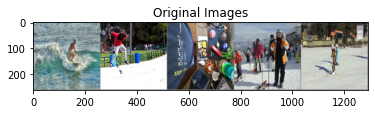

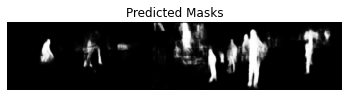

In [ ]:
# Defining testing pipeline here
def show_batch(sample_batched, fig_pos, plt_name):
    plt.figure(fig_pos)
    grid = utils.make_grid(sample_batched)
    MEAN = torch.tensor([0.485])
    STD = torch.tensor([0.229])
    if fig_pos ==1:
      grid = grid * STD + MEAN
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(plt_name)
from random import randrange
print(device)
test_dataset = MaskData(test_images,test_labels, True)
test_data_loader = DataLoader(test_dataset, batch_size=5, num_workers=2,shuffle=True)
with torch.no_grad():
  unetresnet.eval()
  preds = []
  im    = []
  for j, sample_data in enumerate(test_data_loader):
    batch_in  = sample_data['img_in']
    batch_gt = sample_data['img_gt']
    batch_in = batch_in.to(device)
    batch_gt = batch_gt.to(device)
    out = unetresnet(batch_in)
    preds.append(out.cpu())
    im.append(batch_in.cpu())


#random 5 samples for displa
random_index = randrange(len(preds))
show_batch(im[random_index], 1, 'Original Images')
show_batch(preds[random_index], 2, 'Predicted Masks')
plt.axis('off')
plt.ioff()
plt.show()


### Completing the pipeline
Now that as we've successfully built our segmentation model, we can move onto the exciting part where I'll be using the segmentation mask obtained from the model to blur/replace the background.

**NOTE: For background replacement, you can use any picture of your choice (Surprise me!)**

In [ ]:
from PIL import Image, ImageFilter
import numpy
def background_blur(image1, segmentation_model):
  image = transform_in(image1)
  image = image.unsqueeze(0)
  mask  = segmentation_model(image)
  mask  = mask.squeeze(0)

  mask  = np.transpose(mask.cpu().detach().numpy(), (1,2,0))
  mask = mask.squeeze(2)

  mask_3d = mask[:,:,np.newaxis].repeat(3,axis=2)
  blurred_image = image1.filter(ImageFilter.GaussianBlur(radius=30))
  image = np.where(mask_3d>0.5 ,image1.resize((256,256)), blurred_image.resize((256,256)))
  return image

def background_replacement(image1, new_background, segmentation_model):
  image = transform_in(image1)
  image = image.unsqueeze(0)
  mask  = segmentation_model(image)
  mask  = mask.squeeze(0)
  mask  = np.transpose(mask.cpu().detach().numpy(), (1,2,0))
  mask = mask.squeeze(2)
  mask_3d = mask[:,:,np.newaxis].repeat(3,axis=2)
  image = np.where(mask_3d>0.5 ,image1.resize((256,256)), new_background.resize((256,256)))
  return image


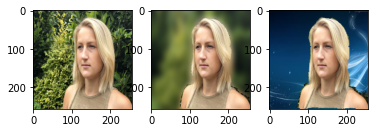

In [ ]:
im = Image.open('/content/drive/MyDrive/Data_Science/image2.jpeg')
background = Image.open('/content/drive/Mydrive/Data_Science/background.jpeg')
segmentation_model = UnetResNet34(1)
segmentation_model.load_state_dict(torch.load('/content/drive/MyDrive/Data_Science/resnet_task3.pt'))
with torch.no_grad():
  segmentation_model.eval()
  blur_image = Image.fromarray(background_blur(im,segmentation_model))
  replace_back_image = Image.fromarray(background_replacement(im,background,segmentation_model))
fig = plt.figure()
fig.add_subplot(1, 3, 1)
plt.imshow(im.resize((256,256)))
fig.add_subplot(1, 3, 2)
plt.imshow(blur_image.resize((256,256)))
fig.add_subplot(1, 3, 3)
plt.imshow(replace_back_image.resize((256,256)))